In [2]:
import time
t_start = time.time()

import sys
import os
import glob

import pandas as pd
import numpy as np
import multiprocessing
from matplotlib import pyplot as plt

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")
print("Home path:", HOME_PATH)
# custom modules
import paper_plot as pp
import full_data as data

Home path: /root/work/QE-mls
['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']


In [ ]:
# ML libraries need to after other packages imported
import tensorflow as tf
print("Tensorflow:", tf.__version__)
import tensorflow_probability as tfp
print("Tensorflow Probability:", tfp.__version__)

# tf.config.run_functions_eagerly(True) # use for print numpy in tf functions (debugging)
# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
gpu_ind = 0
# tf.config.experimental.set_memory_growth(gpus[gpu_ind], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[gpu_ind], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[gpu_ind], True)
        
        # Instead of enabling memory growth, set a memory limit
        # memory_limit = 16_376 / 3 # Set the memory limit in MB
        memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[gpu_ind],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split

2025-03-11 14:11:29.361106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.13.0
Tensorflow Probability: 0.21.0
2 Physical GPUs, 1 Logical GPU


2025-03-11 14:11:31.680770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
# ROOT need to be imported after tensorflow
import ROOT
from ROOT import TLorentzVector, TVector3

# some global variables
plot = pp.Plotter()
WORKERS = 16
SEED = 42  # set random seed (global variable)
GEV = 1e-3

# training variables
SIGMA_LST=[5.0, 50.0, 200.0, 500.0]
BATCH_SIZE = 512
EPOCHS = 2
LEARNING_RATE = 1e-5

Welcome to JupyROOT 6.28/04


In [ ]:
# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
mc_weight = data.MC_weight()

In [ ]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22  # 22 ~ 40 (SY)
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

0
29961
44269
89634
157782


In [ ]:
def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)


def deta(eta1, eta2):
    return np.abs(eta1 - eta2)


def dphi_pi(phi1, phi2):
    phi_diff = phi1 - phi2
    phi_diff = np.where(phi_diff < 0.0, -phi_diff, phi_diff)
    phi_diff = np.where(phi_diff > 2.0 * np.pi, phi_diff - 2.0 * np.pi, phi_diff)
    phi_diff = np.where(phi_diff >= np.pi, 2.0 * np.pi - phi_diff, phi_diff)
    return np.divide(phi_diff, np.pi)

In [ ]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
    [truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
    axis=1,
).to_numpy()
truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
    [
        truth_sublead_lep_px,
        truth_sublead_lep_py,
        truth_sublead_lep_pz,
        truth_sublead_lep_energy,
    ],
    axis=1,
).to_numpy()
truth_dilep_dphi = pd.DataFrame(
    truth_lead_lep.phi[PRE_CUT] - truth_sublead_lep.phi[PRE_CUT]
)
truth_dilep_deta = pd.DataFrame(
    truth_lead_lep.eta[PRE_CUT] - truth_sublead_lep.eta[PRE_CUT]
)
# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
    [lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
    axis=1,
).to_numpy()
sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
    [sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
    axis=1,
).to_numpy()
met_px = pd.DataFrame(met.px[PRE_CUT])
met_py = pd.DataFrame(met.py[PRE_CUT])
met_phi = pd.DataFrame(met.phi[PRE_CUT])

# advanced features
ll_phi = phi(lead_lep.px[PRE_CUT] + sublead_lep.px[PRE_CUT], lead_lep.py[PRE_CUT] + sublead_lep.py[PRE_CUT])
ll_eta = eta(lead_lep.px[PRE_CUT] + sublead_lep.px[PRE_CUT], lead_lep.py[PRE_CUT] + sublead_lep.py[PRE_CUT], lead_lep.pz[PRE_CUT] + sublead_lep.pz[PRE_CUT])
ll_deta = deta(lead_lep.eta[PRE_CUT], sublead_lep.eta[PRE_CUT])
ll_dphi = dphi_pi(lead_lep.phi[PRE_CUT], sublead_lep.phi[PRE_CUT])
metl0_dphi = dphi_pi(met.phi[PRE_CUT], lead_lep.phi[PRE_CUT])
metl1_dphi = dphi_pi(met.phi[PRE_CUT], sublead_lep.phi[PRE_CUT])
metll_dphi = dphi_pi(met.phi[PRE_CUT], ll_phi)

# Concatenate along axis=1 to get N×7 shape
two_part_features = np.vstack([
    ll_phi,
    ll_eta,
    ll_deta,
    ll_dphi,
    metl0_dphi,
    metl1_dphi,
    metll_dphi,
]).T

print(f"Shape of two_part_features: {two_part_features.shape}")

Shape of two_part_features: (851115, 7)


In [ ]:
## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep_px,
        lead_lep_py,
        lead_lep_pz,
        lead_lep_energy,
        sublead_lep_px,
        sublead_lep_py,
        sublead_lep_pz,
        sublead_lep_energy,
        met_px,
        met_py,
        # met_phi,
        # dilep_deta,
        # dilep_dphi,
        # np.log(sublead_lep.energy),
        # np.log(lead_lep.energy),
        # lead_lep.eta,
        # sublead_lep.eta,
    )
)

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

# ROBUST_OBS = RobustScaler()
# obs_kin = ROBUST_OBS.fit_transform(obs_kin)
# print(type(obs_kin))

int_kin shape: (851115, 10)


In [ ]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        w_lead_m,  # calculate MMD
        w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (851115, 10)
<class 'numpy.ndarray'>


In [ ]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)

train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Observed)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Interested)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 851115
X (Interest)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).
Y (Observed)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).


In [ ]:
# create datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (tf.cast(train_x, tf.float32), tf.cast(train_y, tf.float32))
    )
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (tf.cast(valid_x, tf.float32), tf.cast(valid_y, tf.float32))
    )
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# Loss functions

def compute_mmd(x, y, sigma_list=SIGMA_LST):
    # Ensure inputs are at least 2D tensors
    x = tf.reshape(x, [-1, 1])  # Add a dimension to make it [N, 1]
    y = tf.reshape(y, [-1, 1])  # Add a dimension to make it [M, 1]

    # Compute Gram Matrices (dot products)
    xx = tf.linalg.matmul(x, tf.transpose(x))  # (N, N)
    yy = tf.linalg.matmul(y, tf.transpose(y))  # (M, M)
    xy = tf.linalg.matmul(x, tf.transpose(y))  # (N, M)

    # Extract diagonal elements (squared norms)
    diag_xx = tf.linalg.diag_part(xx)  # (N,)
    diag_yy = tf.linalg.diag_part(yy)  # (M,)

    # Compute squared Euclidean distances
    dxx = tf.expand_dims(diag_xx, 0) + tf.expand_dims(diag_xx, 1) - 2.0 * xx  # (N, N)
    dyy = tf.expand_dims(diag_yy, 0) + tf.expand_dims(diag_yy, 1) - 2.0 * yy  # (M, M)
    dxy = tf.expand_dims(diag_xx, 1) + tf.expand_dims(diag_yy, 0) - 2.0 * xy  # (N, M)

    # Initialize Kernel Matrices
    XX = tf.zeros_like(xx, dtype=tf.float32)
    YY = tf.zeros_like(yy, dtype=tf.float32)
    XY = tf.zeros_like(xy, dtype=tf.float32)

    # Multi-scale Gaussian Kernel
    for sigma in sigma_list:  # Different bandwidths
        XX += tf.exp(-dxx / (2.0 * tf.square(sigma)))
        YY += tf.exp(-dyy / (2.0 * tf.square(sigma)))
        XY += tf.exp(-dxy / (2.0 * tf.square(sigma)))

    # Compute MMD
    mmd_value = tf.reduce_mean(XX + YY - 2.0 * XY)
    return mmd_value


def w_mass_loss_fn(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    w0_4Vect = y_pred[..., :4]
    w0_true_mass = y_true[..., 8]
    w1_4Vect = y_pred[..., 4:8]
    w1_true_mass = y_true[..., 9]

    w0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(w0_4Vect[..., 3])
                - tf.reduce_sum(tf.square(w0_4Vect[..., :3]), axis=-1)
            ),
            1e-10,
        )
    )
    w1_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(w1_4Vect[..., 3])
                - tf.reduce_sum(tf.square(w1_4Vect[..., :3]), axis=-1)
            ),
            1e-10,
        )
    )

    # MMD
    mmd0 = compute_mmd(w0_mass, w0_true_mass)
    mmd1 = compute_mmd(w1_mass, w1_true_mass)
    return mmd0, mmd1


def nu_mass_loss_fn(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]

    nu0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(n0_4vect[..., 3])
                - tf.reduce_sum(tf.square(n0_4vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )
    nu1_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(n1_4vect[..., 3])
                - tf.reduce_sum(tf.square(n1_4vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )

    return tf.reduce_mean(nu0_mass + nu1_mass)


def dinu_pt_loss_fn(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]

    nn_4vect = n0_4vect + n1_4vect
    nn_px = nn_4vect[..., 0]
    nn_py = nn_4vect[..., 1]

    nn_px_diff = tf.math.maximum(tf.abs(nn_px - x_batch[..., 8]), _epsilon)
    nn_py_diff = tf.math.maximum(tf.abs(nn_py - x_batch[..., 9]), _epsilon)

    return tf.reduce_mean(nn_px_diff + nn_py_diff)


def higgs_mass_loss_fn(y_pred):
    _epsilon = 1e-10
    y_pred = tf.cast(y_pred, tf.float32)

    w0_4Vect = y_pred[..., :4]
    w1_4Vect = y_pred[..., 4:8]
    higgs_4Vect = w0_4Vect + w1_4Vect

    higgs_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(higgs_4Vect[..., 3])
                - tf.reduce_sum(tf.square(higgs_4Vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )

    return tf.reduce_mean(tf.abs(higgs_mass - 125.0)) + _epsilon


def mae_loss_fn(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.keras.losses.mae(y_true, y_pred))


def neg_r2_loss_fn(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # minimize the negative r2 score
    return (
        tf.reduce_sum(tf.square(y_true - y_pred))
        / tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        - 1
    )

In [ ]:
@register_keras_serializable(package="ww_regressor")
class CustomModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.current_epoch = tf.Variable(0.0, trainable=False)

        # Initialize metrics dictionary with lambda_weight
        self.metric_dict = {
            "mae_loss": tf.keras.metrics.Mean(name="mae1_loss"),
            "nu_mass_loss": tf.keras.metrics.Mean(name="nu_mass_loss"),
            "w_mass_mmd0_loss": tf.keras.metrics.Mean(name="w_mass_mmd0_loss"),
            "w_mass_mmd1_loss": tf.keras.metrics.Mean(name="w_mass_mmd1_loss"),
            "higgs_mass_loss": tf.keras.metrics.Mean(name="higgs_mass_loss"),
            "dinu_pt_loss": tf.keras.metrics.Mean(name="dinu_pt_loss"),
            "neg_r2_loss": tf.keras.metrics.Mean(name="neg_r2_loss"),
            "loss": tf.keras.metrics.Mean(name="loss"),
        }

    def call(self, inputs, training=None):
        return self.base_model(inputs, training=training)

    def get_config(self):
        # Grab parent config (includes trainable, dtype, etc.)
        config = super().get_config()
        # Serialize base_model
        config["base_model"] = tf.keras.utils.serialize_keras_object(self.base_model)
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        # Extract the base_model config and remove other keras-specific params
        base_model_config = config.pop("base_model", None)

        # Remove standard keras params that aren't needed for your __init__
        # These are automatically included in the config but not used by your constructor
        for key in ["name", "trainable", "dtype"]:
            if key in config:
                config.pop(key)

        if base_model_config is not None:
            base_model = tf.keras.utils.deserialize_keras_object(
                base_model_config, custom_objects=custom_objects
            )
        else:
            # Fallback: create a new base_model or raise an error
            raise ValueError(
                "No 'base_model' found in config—cannot rebuild the original model."
            )

        # Now only pass the base_model and any custom params that your __init__ accepts
        return cls(base_model=base_model)

    def compile(self, optimizer, loss_weights=None, **kwargs):
        super().compile(optimizer=optimizer, **kwargs)
        default_weights = {
            "mae": 1.0,
            "nu_mass": 0.0,
            "higgs_mass": 0.0,
            "w_mass_mmd0": 0.0,
            "w_mass_mmd1": 0.0,
            "dinu_pt": 0.0,
            "neg_r2": 0.0,
            "fused_output": 0.0,
        }
        self.loss_weights = {**default_weights, **(loss_weights or {})}

    @property
    def metrics(self):
        return list(self.metric_dict.values())

    def _compute_losses(self, x, y, predictions):
        # Unpack four outputs: [fused_output, nu_mass_output, mae_output, lambda_weight]
        outputs = predictions

        losses = {
            "mae": mae_loss_fn(y, outputs),
            "nu_mass": nu_mass_loss_fn(x, outputs),
            "higgs_mass": higgs_mass_loss_fn(outputs),
            "w_mass_mmd0": w_mass_loss_fn(y, outputs)[0],
            "w_mass_mmd1": w_mass_loss_fn(y, outputs)[1],
            "dinu_pt": dinu_pt_loss_fn(x, outputs),
            "neg_r2": neg_r2_loss_fn(y, outputs),
        }

        total_loss = tf.add_n(
            [self.loss_weights[name] * loss for name, loss in losses.items()]
        )

        return total_loss, losses

    def _update_metrics(self, total_loss, losses):
        """Helper method to update metrics"""
        self.metric_dict["loss"].update_state(total_loss)
        for name, loss in losses.items():
            self.metric_dict[f"{name}_loss"].update_state(loss)
        # self.metric_dict['lambda_weight'].update_state(tf.reduce_mean(lambda_weight))  # Track mean

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            total_loss, losses = self._compute_losses(x, y, predictions)

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self._update_metrics(total_loss, losses)

        return {name: metric.result() for name, metric in self.metric_dict.items()}

    def test_step(self, data):
        x, y = data
        predictions = self(x, training=False)
        total_loss, losses = self._compute_losses(x, y, predictions)

        self._update_metrics(total_loss, losses)

        return {name: metric.result() for name, metric in self.metric_dict.items()}

In [ ]:
@register_keras_serializable(package="nu_regressor")
class WBosonFourVectorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WBosonFourVectorLayer, self).__init__(**kwargs)

    def call(self, inputs):
        lep0, lep1, nu_3mom = inputs
        nu0_3mom = nu_3mom[..., :3]  # [px, py, pz] for nu0
        nu1_3mom = nu_3mom[..., 3:]  # [px, py, pz] for nu1
        nu0_p_squared = tf.reduce_sum(tf.square(nu0_3mom), axis=-1, keepdims=True)
        nu1_p_squared = tf.reduce_sum(tf.square(nu1_3mom), axis=-1, keepdims=True)
        nu0_energy = tf.sqrt(tf.maximum(nu0_p_squared, 1e-10))
        nu1_energy = tf.sqrt(tf.maximum(nu1_p_squared, 1e-10))
        nu0_4vect = tf.concat([nu0_3mom, nu0_energy], axis=-1)
        nu1_4vect = tf.concat([nu1_3mom, nu1_energy], axis=-1)
        w0_4vect = lep0 + nu0_4vect
        w1_4vect = lep1 + nu1_4vect
        return tf.concat([w0_4vect, w1_4vect], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], 8)

    def get_config(self):
        config = super(WBosonFourVectorLayer, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
def dense_dropout_block(x, units, activation="swish", dropout_rate=0.0, l2=0.0):
    x = tf.keras.layers.Dense(
        units=units,
        use_bias=True,
        kernel_initializer="he_normal",
        kernel_regularizer=tf.keras.regularizers.L2(l2),
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    return x


def residual_block(x, units, activation="swish", dropout_rate=0.0, l2=0.0):
    y = dense_dropout_block(
        x, units, activation=activation, dropout_rate=dropout_rate, l2=l2
    )
    y = dense_dropout_block(
        y, units, activation=activation, dropout_rate=dropout_rate, l2=l2
    )
    if x.shape[-1] != units:
        x = tf.keras.layers.Dense(units, activation=None, use_bias=False)(x)
    z = tf.keras.layers.Add()([x, y])
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.Activation(activation)(z)
    return z

In [ ]:
def build_model(input_shape):
    inputs = tf.keras.layers.Input(shape=(input_shape,), dtype=tf.float32)
    x, y = inputs, inputs

    # Extract lepton 4-vectors for Subnet 1
    lep0 = inputs[..., :4]  # [px, py, pz, e] for leading lepton
    lep1 = inputs[..., 4:8]  # [px, py, pz, e] for subleading lepton

    # Subnet 1 --> Predict neutrino 3-momenta and apply physics layer
    for _ in range(2):
        x = residual_block(x, 128, dropout_rate=0.4, l2=1e-4)
        x = residual_block(x, 64, dropout_rate=0.4, l2=1e-4)
    for _ in range(2):
        # x = residual_block(x, 512, dropout_rate=0.4, l2=1e-4)
        x = residual_block(x, 256, dropout_rate=0.4, l2=1e-4)
        x = residual_block(x, 256, dropout_rate=0.4, l2=1e-4)
    for _ in range(2):
        x = residual_block(x, 64, dropout_rate=0.4, l2=1e-4)
        x = residual_block(x, 32, dropout_rate=0.4, l2=1e-4)
    # Bottleneck
    x = tf.keras.layers.Dense(16, activation=None, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("swish")(x)
    # neutrino layer
    nu_3mom = tf.keras.layers.Dense(
        units=6, activation="linear", kernel_initializer="he_normal"
    )(x)
    neutrino_outputs = WBosonFourVectorLayer()([lep0, lep1, nu_3mom])
    # w0 mass layer
    w0_mass = tf.keras.layers.Dense(
        units=1, activation="relu", kernel_initializer="he_normal"
    )(
        x
    )  # always positive
    # w1 mass layer
    w1_mass = tf.keras.layers.Dense(
        units=1, activation="relu", kernel_initializer="he_normal"
    )(
        x
    )  # always positive

    # last layer
    outputs = tf.keras.layers.Concatenate()([neutrino_outputs, w0_mass, w1_mass])

    return tf.keras.Model(inputs=inputs, outputs=[outputs])

In [ ]:
# Build and compile model
input_shape = train_x.shape[-1]
base_model = build_model(input_shape)
model = CustomModel(base_model)
model.build((None, input_shape))
model.summary()

# Model compilation with weights dictionary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_weights={
        "mae": 1.0,
        "nu_mass": 0,
        "higgs_mass": 0,
        "w_mass_mmd0": 10.0,
        "w_mass_mmd1": 10.0,
        "dinu_pt": 0,
        "neg_r2": 0,
    },
    jit_compile=True,
    steps_per_execution=256,
)


# Updated callbacks
class EpochUpdater(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.model.current_epoch.assign(float(epoch))


class LambdaTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch_num = int(self.model.current_epoch.numpy())
        log_str = f"Epoch {epoch_num}"
        # Log all metrics
        for name, value in logs.items():
            log_str += f"; {name}: {value:.4f}"
        print(log_str)


callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    ),
    EpochUpdater(),
    LambdaTracker(),
]

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=0,
)

# Print the weights
print("\nModel Loss Weights:")
for name, weight in model.loss_weights.items():
    print(f"{name:12s}: {weight:.3f}")

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 10)                662616    
                                                                 
Total params: 662633 (2.53 MB)
Trainable params: 652984 (2.49 MB)
Non-trainable params: 9649 (37.69 KB)
_________________________________________________________________
Epoch 0; mae_loss: 41.0654; nu_mass_loss: 0.0021; w_mass_mmd0_loss: 2.2043; w_mass_mmd1_loss: 1.2937; higgs_mass_loss: 82.1799; dinu_pt_loss: 67.1169; neg_r2_loss: -0.5310; loss: 76.0455; val_mae_loss: 41.0443; val_nu_mass_loss: 0.0017; val_w_mass_mmd0_loss: 2.2978; val_w_mass_mmd1_loss: 1.4040; val_higgs_mass_loss: 84.1809; val_dinu_pt_loss: 67.0723; val_neg_r2_loss: -0.5284; val_loss: 78.0625
Epoch 1; mae_loss: 41.0268; nu_mass_loss: 0.0026; w_mass_mmd0_loss: 2.0756; w_mass_mmd1_loss: 1.2159; higgs_mass_loss: 81.2120; dinu_pt_loss: 67.1

2025-03-11 14:11:56.340868: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c92af481e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-11 14:11:56.340932: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-03-11 14:11:56.908942: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-11 14:11:57.238704: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. custom_model/model/dropout/dropout/random_uniform/RandomUniform
2025-03-11 14:12:00.852848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-03-11 14:12:16.669416: I tensorflow/compile

In [ ]:
# Make a directory
dir_name = HOME_PATH + "/12th_trial/reg_main/ww_resregressor_result/"
savedmodel_path = dir_name + "saved_model"
name = "ww_resregressor"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            if os.path.isdir(file):
                # Use shutil.rmtree to remove directories
                import shutil
                shutil.rmtree(file)
            else:
                # Use os.remove for regular files
                os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")


try:
    # Save model
    model.save(dir_name + name + ".tf", save_format="tf", overwrite=True)
    # Save model in saved_model format for ONNX conversion
    tf.saved_model.save(model, savedmodel_path)
    print(f"Model saved in {dir_name}.")
except Exception as e:
    print(f"Error: {e}")

Directory /root/work/QE-mls/12th_trial/reg_main/ww_resregressor_result/ cleaned.
Directory /root/work/QE-mls/12th_trial/reg_main/ww_resregressor_result/ exists.
INFO:tensorflow:Assets written to: /root/work/QE-mls/12th_trial/reg_main/ww_resregressor_result/ww_resregressor.tf/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/12th_trial/reg_main/ww_resregressor_result/ww_resregressor.tf/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/12th_trial/reg_main/ww_resregressor_result/saved_model/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/12th_trial/reg_main/ww_resregressor_result/saved_model/assets


In [ ]:
model = tf.keras.models.load_model(
    dir_name + name + ".tf", 
    custom_objects={
        "CustomModel": CustomModel,
        "WBosonFourVectorLayer": WBosonFourVectorLayer
    }
)
print("Model loaded successfully.")

# predict
pred_y = model.predict(test_x)

2660/2660 [==============================] - 21s 8ms/step


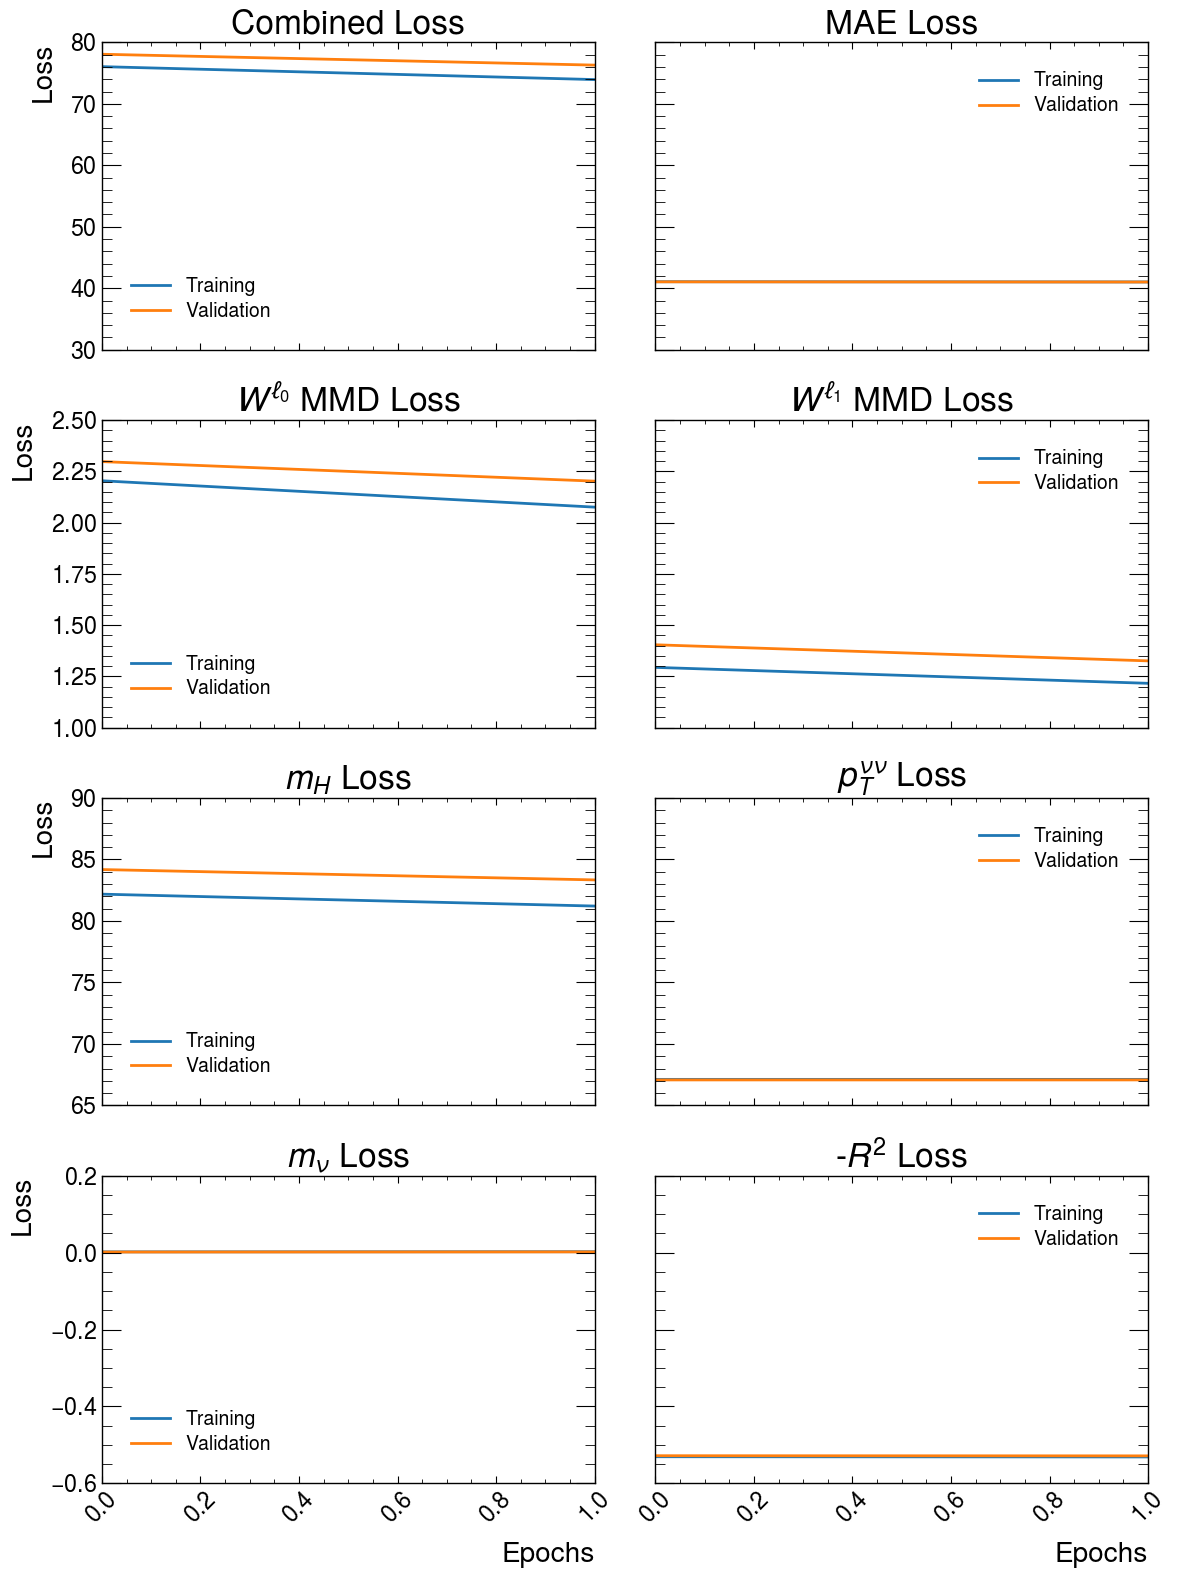

In [ ]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]
mae_loss = history.history["mae_loss"]
val_mae_loss = history.history["val_mae_loss"]
neg_r2_loss = history.history["neg_r2_loss"]
val_neg_r2_loss = history.history["val_neg_r2_loss"]
higgs_mass_loss = history.history["higgs_mass_loss"]
val_higgs_mass_loss = history.history["val_higgs_mass_loss"]
dinu_pt_loss = history.history["dinu_pt_loss"]
val_dinu_pt_loss = history.history["val_dinu_pt_loss"]
nu_mass_loss = history.history["nu_mass_loss"]
val_nu_mass_loss = history.history["val_nu_mass_loss"]
w_mass_mmd0_loss = history.history["w_mass_mmd0_loss"]
val_w_mass_mmd0_loss = history.history["val_w_mass_mmd0_loss"]
w_mass_mmd1_loss = history.history["w_mass_mmd1_loss"]
val_w_mass_mmd1_loss = history.history["val_w_mass_mmd1_loss"]

# Create figure with shared axes
fig, axes = plt.subplots(4, 2, figsize=(12, 16), sharex=True, sharey='row')

# 1) Combined Loss
axes[0, 0].plot(loss, label="Training")
axes[0, 0].plot(val_loss, label="Validation")
axes[0, 0].set_title("Combined Loss")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(False)

# 2) MAE Loss
axes[0, 1].plot(mae_loss, label="Training")
axes[0, 1].plot(val_mae_loss, label="Validation")
axes[0, 1].set_title("MAE Loss")
axes[0, 1].legend()
axes[0, 1].grid(False)

# 3) W MMD0 Loss (moved to 2nd row)
axes[1, 0].plot(w_mass_mmd0_loss, label="Training")
axes[1, 0].plot(val_w_mass_mmd0_loss, label="Validation")
axes[1, 0].set_title(r"$W^{\ell_0}$ MMD Loss")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()
axes[1, 0].grid(False)

# 4) W MMD1 Loss (moved to 2nd row)
axes[1, 1].plot(w_mass_mmd1_loss, label="Training")
axes[1, 1].plot(val_w_mass_mmd1_loss, label="Validation")
axes[1, 1].set_title(r"$W^{\ell_1}$ MMD Loss")
axes[1, 1].legend()
axes[1, 1].grid(False)

# 5) Higgs Mass Loss (moved to 3rd row)
axes[2, 0].plot(higgs_mass_loss, label="Training")
axes[2, 0].plot(val_higgs_mass_loss, label="Validation")
axes[2, 0].set_title(r"$m_{H}$ Loss")
axes[2, 0].set_ylabel("Loss")
axes[2, 0].legend()
axes[2, 0].grid(False)

# 6) Dinu Pt Loss (moved to 3rd row)
axes[2, 1].plot(dinu_pt_loss, label="Training")
axes[2, 1].plot(val_dinu_pt_loss, label="Validation")
axes[2, 1].set_title(r"$p^{\nu\nu}_{T}$ Loss")
axes[2, 1].legend()
axes[2, 1].grid(False)

# 7) Nu Mass Loss (moved to 4th row)
axes[3, 0].plot(nu_mass_loss, label="Training")
axes[3, 0].plot(val_nu_mass_loss, label="Validation")
axes[3, 0].set_title(r"$m_{\nu}$ Loss")
axes[3, 0].set_xlabel("Epochs")
axes[3, 0].set_ylabel("Loss")
axes[3, 0].legend()
axes[3, 0].grid(False)
axes[3, 0].tick_params(axis='x', rotation=45)

# 8) Neg R2 Loss
axes[3, 1].plot(neg_r2_loss, label="Training")
axes[3, 1].plot(val_neg_r2_loss, label="Validation")
axes[3, 1].set_title(r"-$R^2$ Loss")
axes[3, 1].set_xlabel("Epochs")
axes[3, 1].legend()
axes[3, 1].grid(False)
axes[3, 1].tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(dir_name + name + "_loss.png")
plt.show()
plt.close()

In [ ]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=pred_y,
    test_y=test_y,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]
print(f"{dir_name + name}_data.npz has been saved.")

/root/work/QE-mls/12th_trial/reg_main/ww_resregressor_result/ww_resregressor_data.npz has been saved.


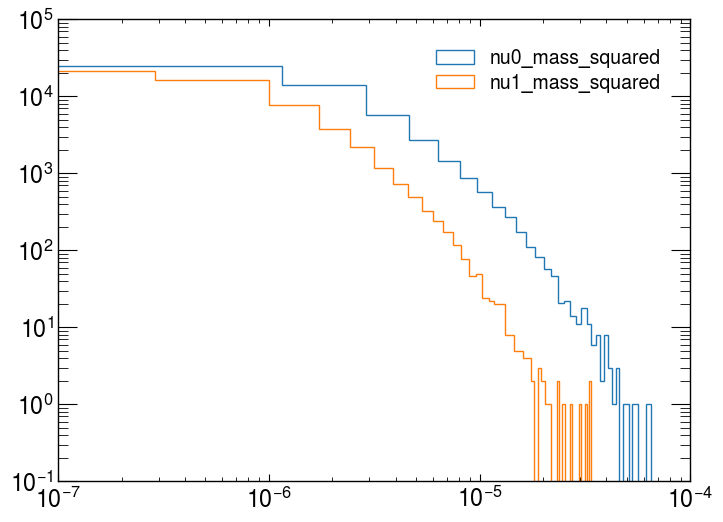

nu0_mass_squared avg: -1.8938098963252265e-08
nu1_mass_squared avg: 5.001190236874721e-10


In [ ]:
# neutrino mass checking
nu0_4vect = sig_pred_inv[:, :4] - test_x[:, :4]
nu1_4vect = sig_pred_inv[:, 4:8] - test_x[:, 4:8]
nu0_mass_squared = (
    np.square(nu0_4vect[:, 3])
    - np.square(nu0_4vect[:, 0])
    - np.square(nu0_4vect[:, 1])
    - np.square(nu0_4vect[:, 2])
)
nu1_mass_squared = (
    np.square(nu1_4vect[:, 3])
    - np.square(nu1_4vect[:, 0])
    - np.square(nu1_4vect[:, 1])
    - np.square(nu1_4vect[:, 2])
)
# nu0_mass_squared
plt.hist(nu0_mass_squared, bins=100, histtype="step", label="nu0_mass_squared")
plt.hist(nu1_mass_squared, bins=100, histtype="step", label="nu1_mass_squared")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()
plt.close()

print("nu0_mass_squared avg:", np.mean(nu0_mass_squared))
print("nu1_mass_squared avg:", np.mean(nu1_mass_squared))
# plt.hist(nu1_mass_squared, bins=100, range=(0, 100), histtype="step", label="nu1_mass_squared")

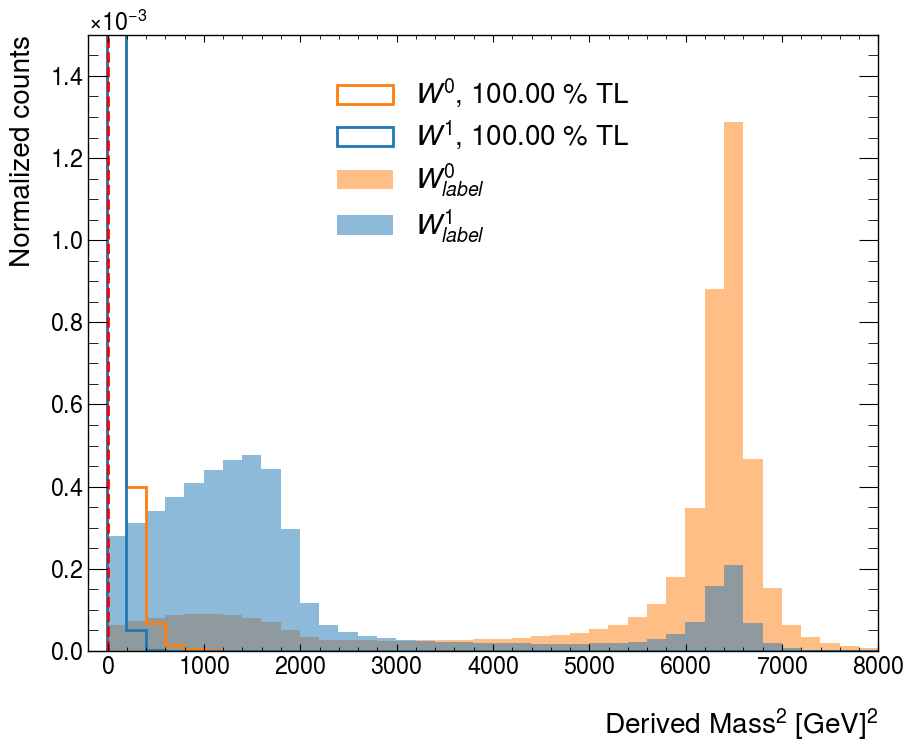

m2 with 100.00 % time-like (TL) evts


In [ ]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:orange",
    histtype="step",
    label=r"$W^{0}$, "
    + f"{100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$, "
    + f"{100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="tab:orange",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{0}$",
    density=True,
    # weights=mc_weight,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{1}$",
    density=True,
    # weights=mc_weight,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-2e2, 8e3)
plt.ylim(0, 1.5e-3)
plt.xlabel(r"Derived Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.legend(
    loc="best",
    ncol=1,
    prop={"size": 20},
    columnspacing=1.0,
    frameon=False,
    framealpha=0.8,
)
plt.show()
plt.close()
print(
    f"m2 with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask):.2f} % time-like (TL) evts"
)

In [ ]:
# TODO: CGLMP


def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
    )


def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))

    # Unpack the results
    bij, xi_p, xi_n = zip(*results)

    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_p[~mask, :],
        xi_n[~mask, :],
    )

In [ ]:
# reco
particles = np.concatenate(
    [
        sig_pred_inv[:, 0:4],
        lead_lep_p4[test_indices],
        sig_pred_inv[:, 4:8],
        sublead_lep_p4[test_indices],
    ],
    axis=1,
)
bij = result_generator(particles)[0][0:80_000, :]
xi_p = result_generator(particles)[1][0:80_000, :]
xi_n = result_generator(particles)[2][0:80_000, :]

# truth
particles = np.concatenate(
    [
        sig_truth_inv[:, 0:4],
        truth_lead_lep_p4[test_indices],
        sig_truth_inv[:, 4:8],
        truth_sublead_lep_p4[test_indices],
    ],
    axis=1,
)
truth_bij = result_generator(particles)[0][0:80_000, :]
truth_xi_p = result_generator(particles)[1][0:80_000, :]
truth_xi_n = result_generator(particles)[2][0:80_000, :]

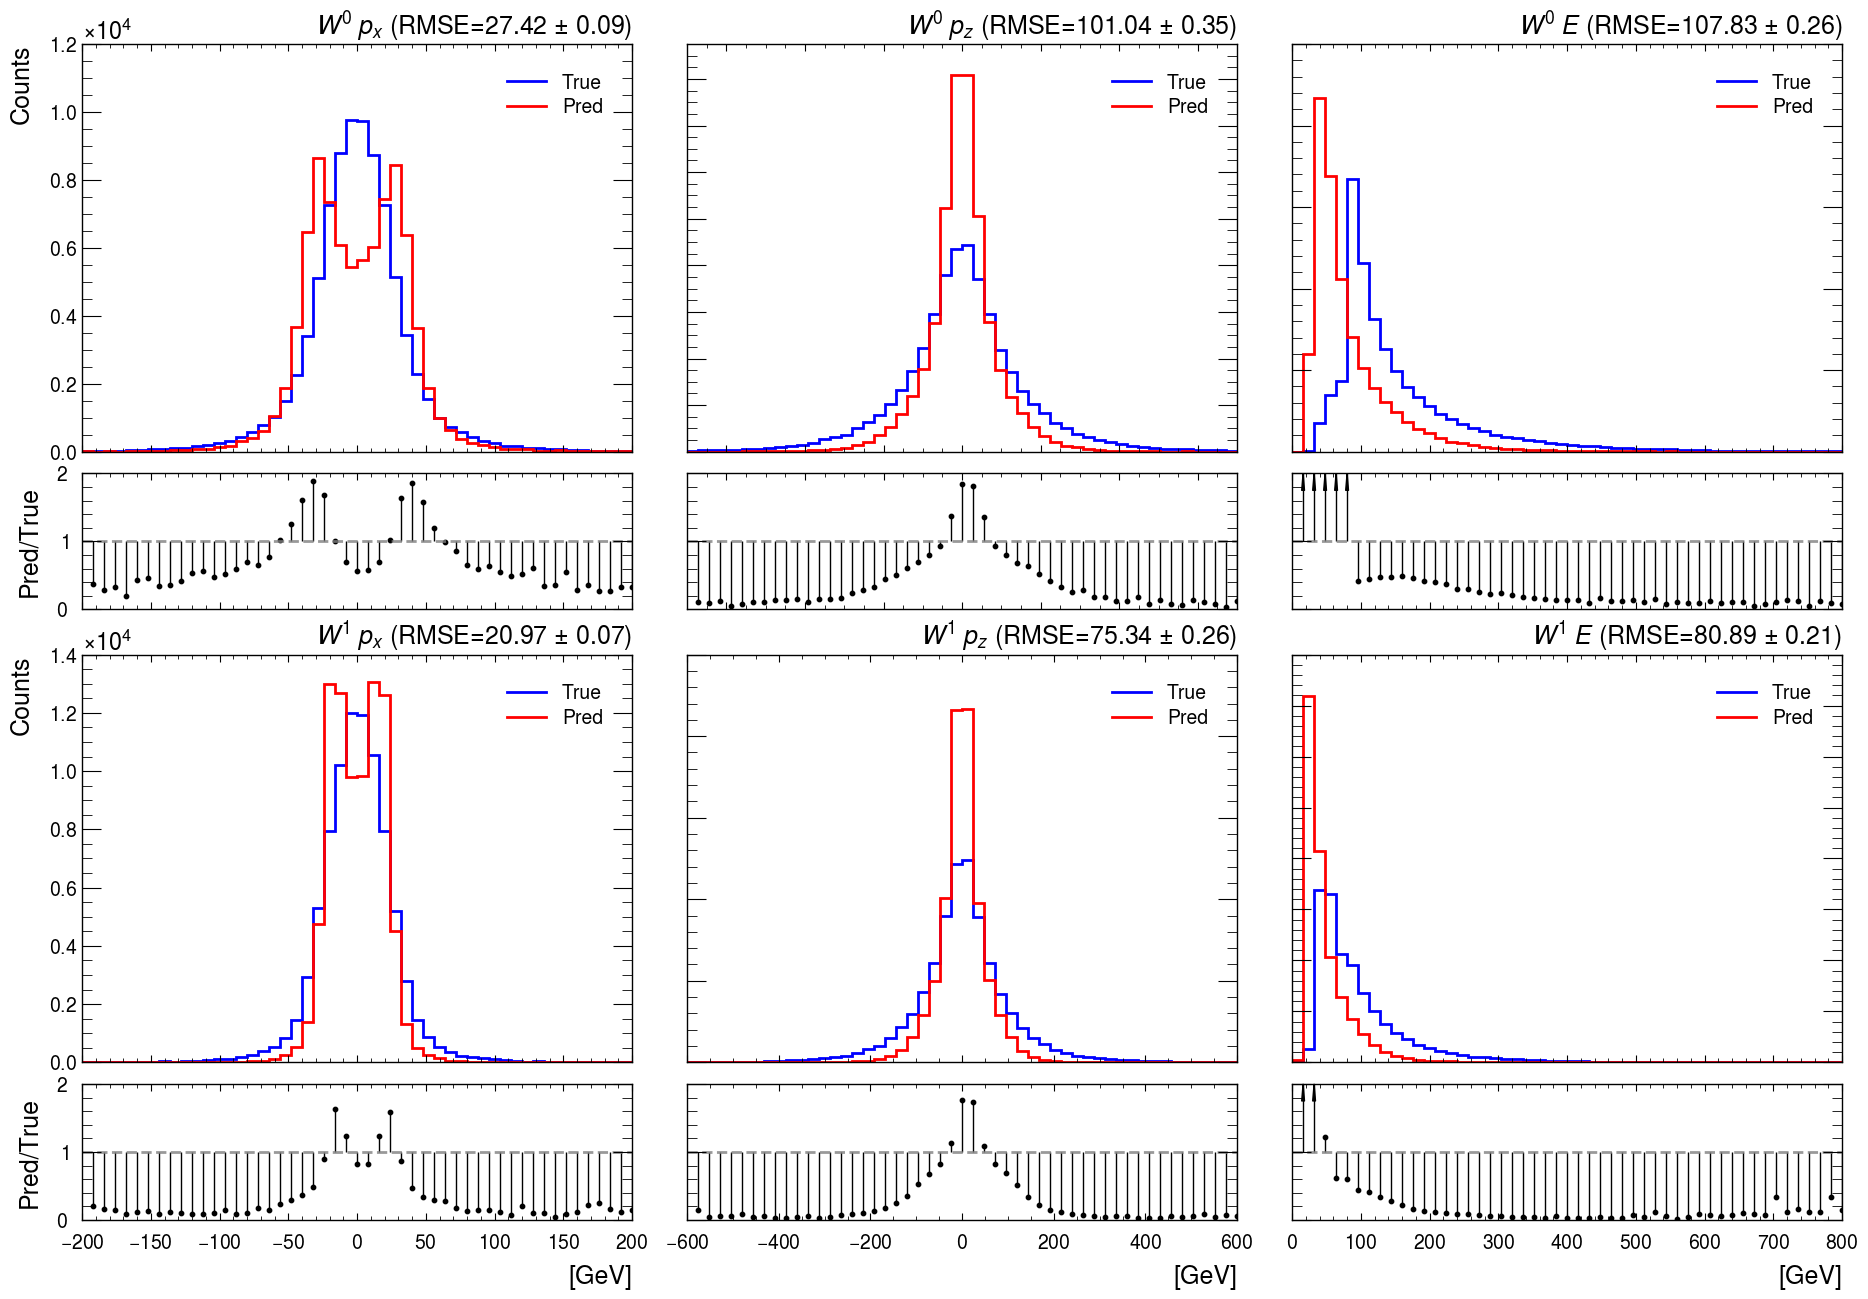

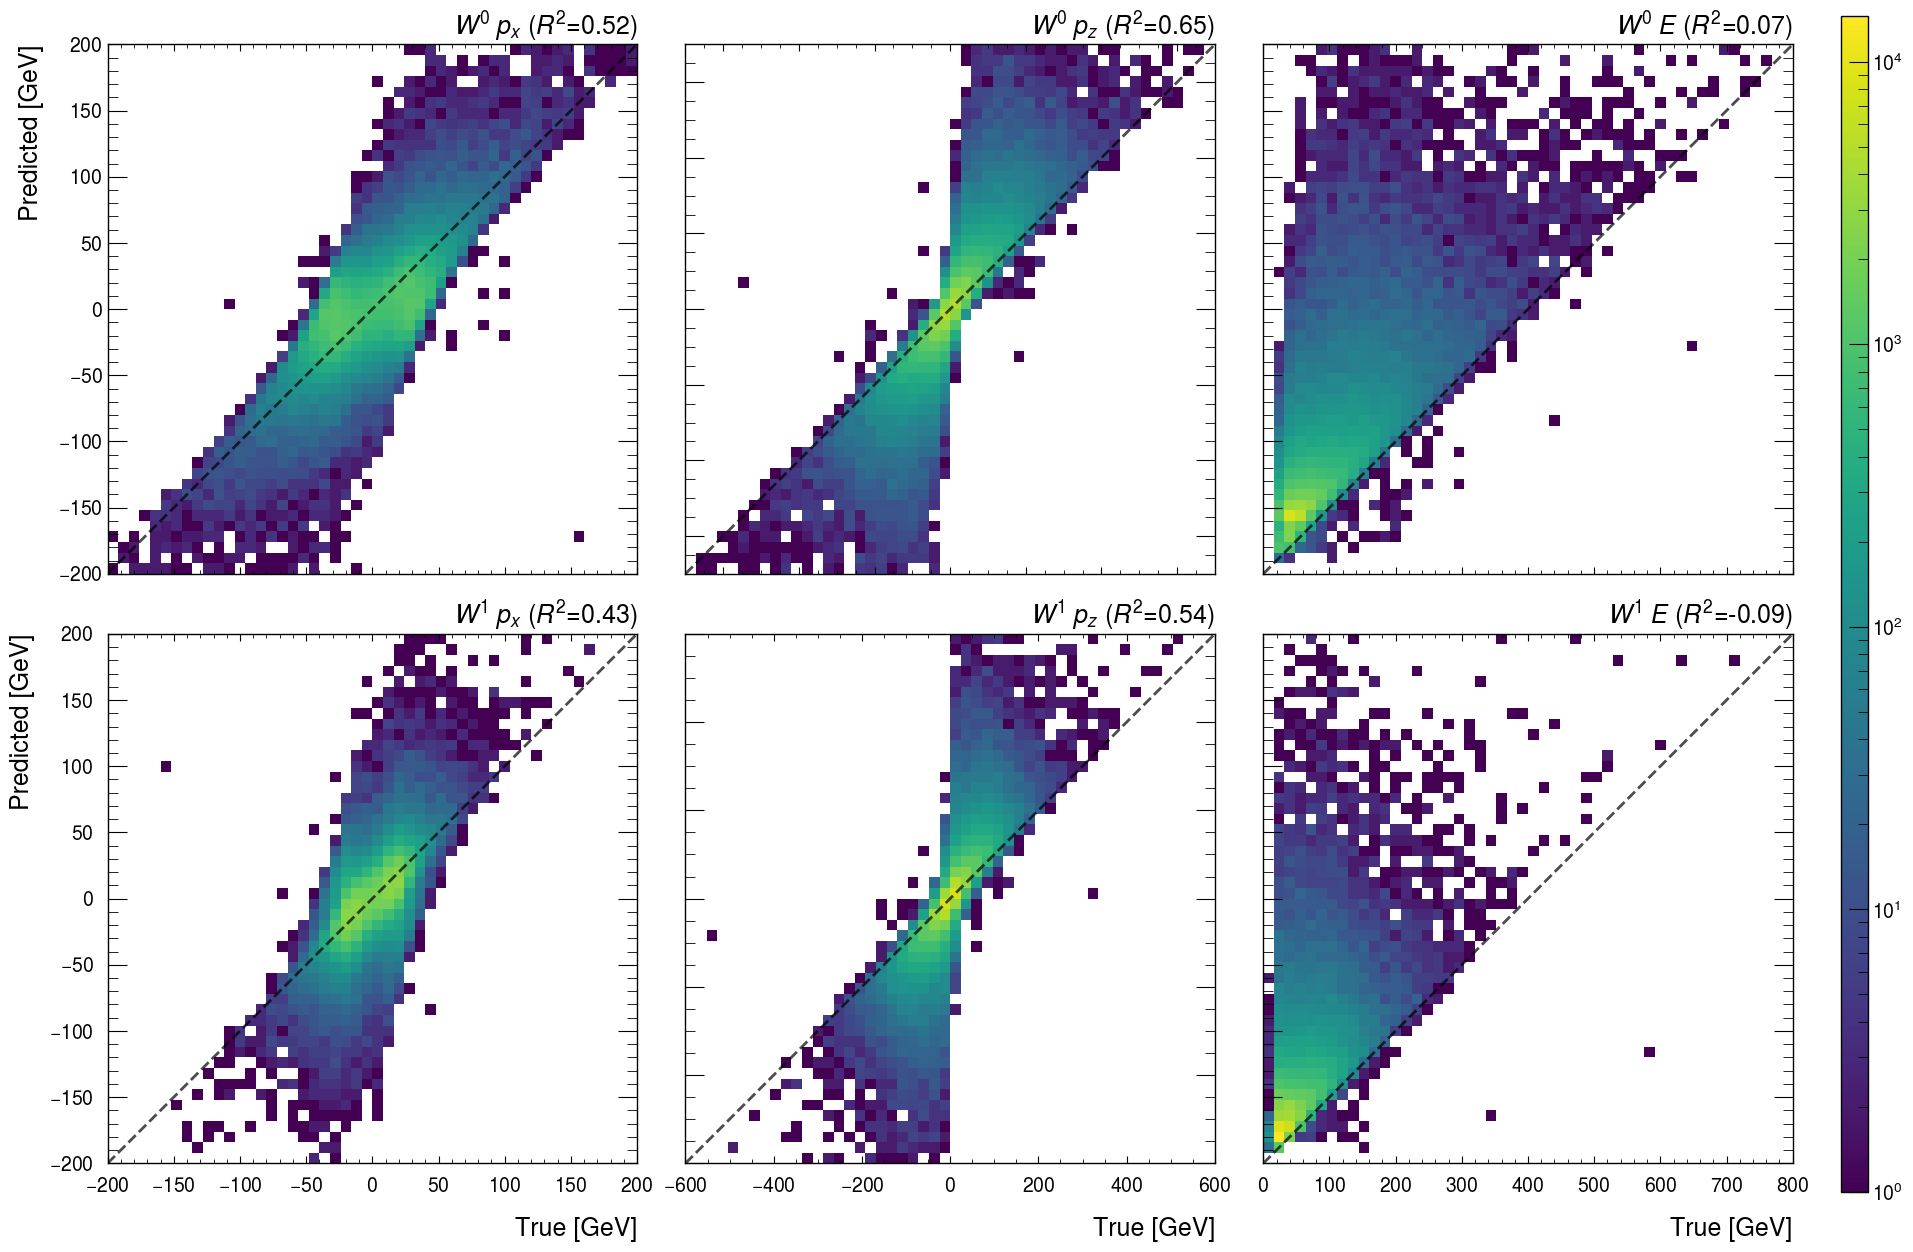

In [ ]:
w_plot_true = [
    sig_truth_inv[:, 0],
    sig_truth_inv[:, 2],
    sig_truth_inv[:, 3],
    sig_truth_inv[:, 4],
    sig_truth_inv[:, 6],
    sig_truth_inv[:, 7],
]
w_plot_pred = [
    sig_pred_inv[:, 0],
    sig_pred_inv[:, 2],
    sig_pred_inv[:, 3],
    sig_pred_inv[:, 4],
    sig_pred_inv[:, 6],
    sig_pred_inv[:, 7],
]
w_plot_ranges = [
    [-200, 200],
    [-700, 700],
    [0, 800],
    [-200, 200],
    [-600, 600],
    [0, 800],
]
w_plot_labels = [
    r"$W^{0}\ p_{x}$",
    r"$W^{0}\ p_{z}$",
    r"$W^{0}\ E$",
    r"$W^{1}\ p_{x}$",
    r"$W^{1}\ p_{z}$",
    r"$W^{1}\ E$",
]
plot.hist_1d_grid(
    w_plot_true,
    w_plot_pred,
    title=w_plot_labels,
    ranges=w_plot_ranges,
    xlabel="[GeV]",
)
plot.hist_2d_grid(
    w_plot_true,
    w_plot_pred,
    title=w_plot_labels,
    ranges=w_plot_ranges,
    xlabel="True [GeV]",
    ylabel="Predicted [GeV]",
)
plt.close()

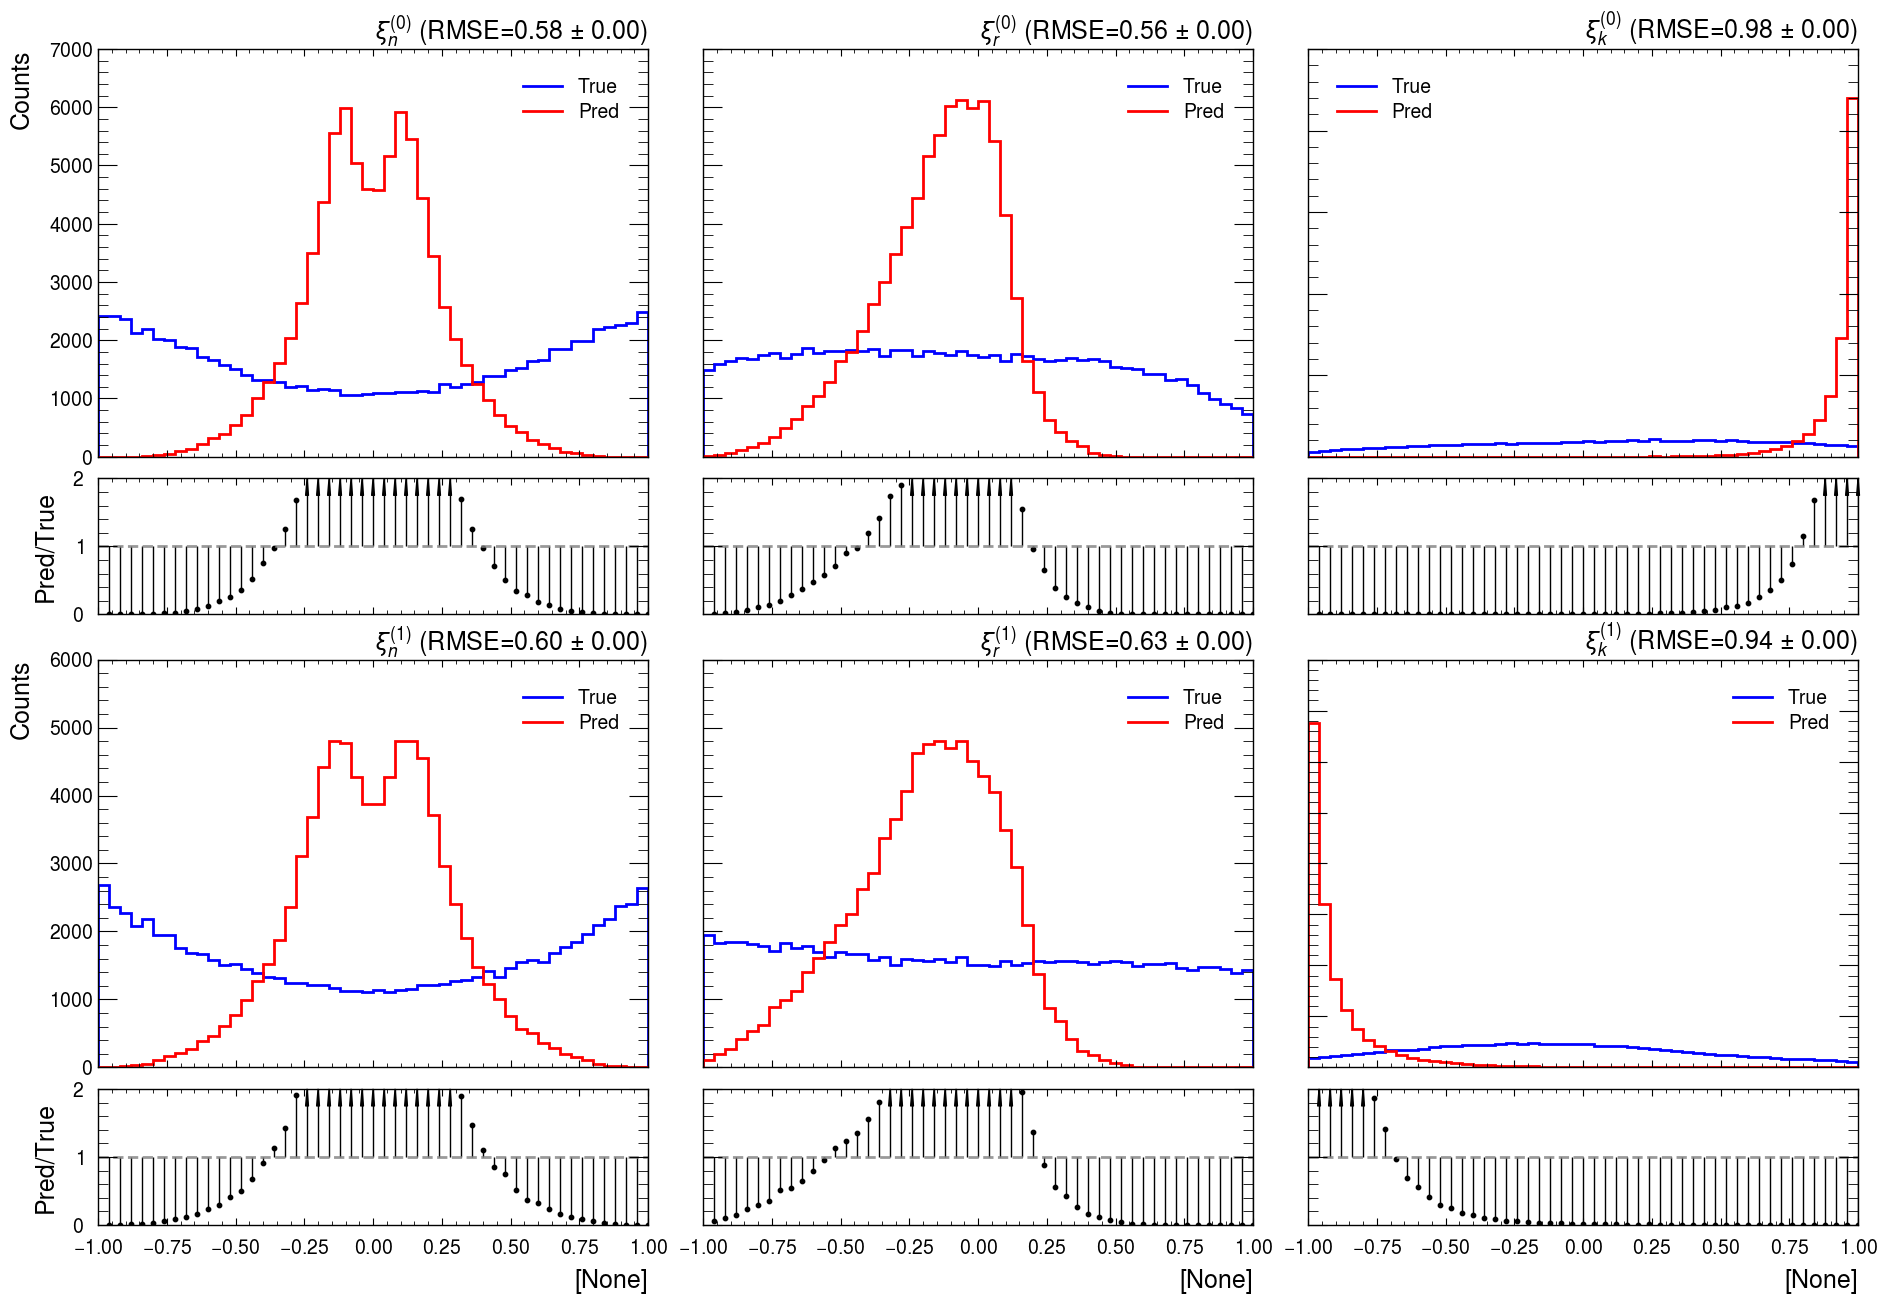

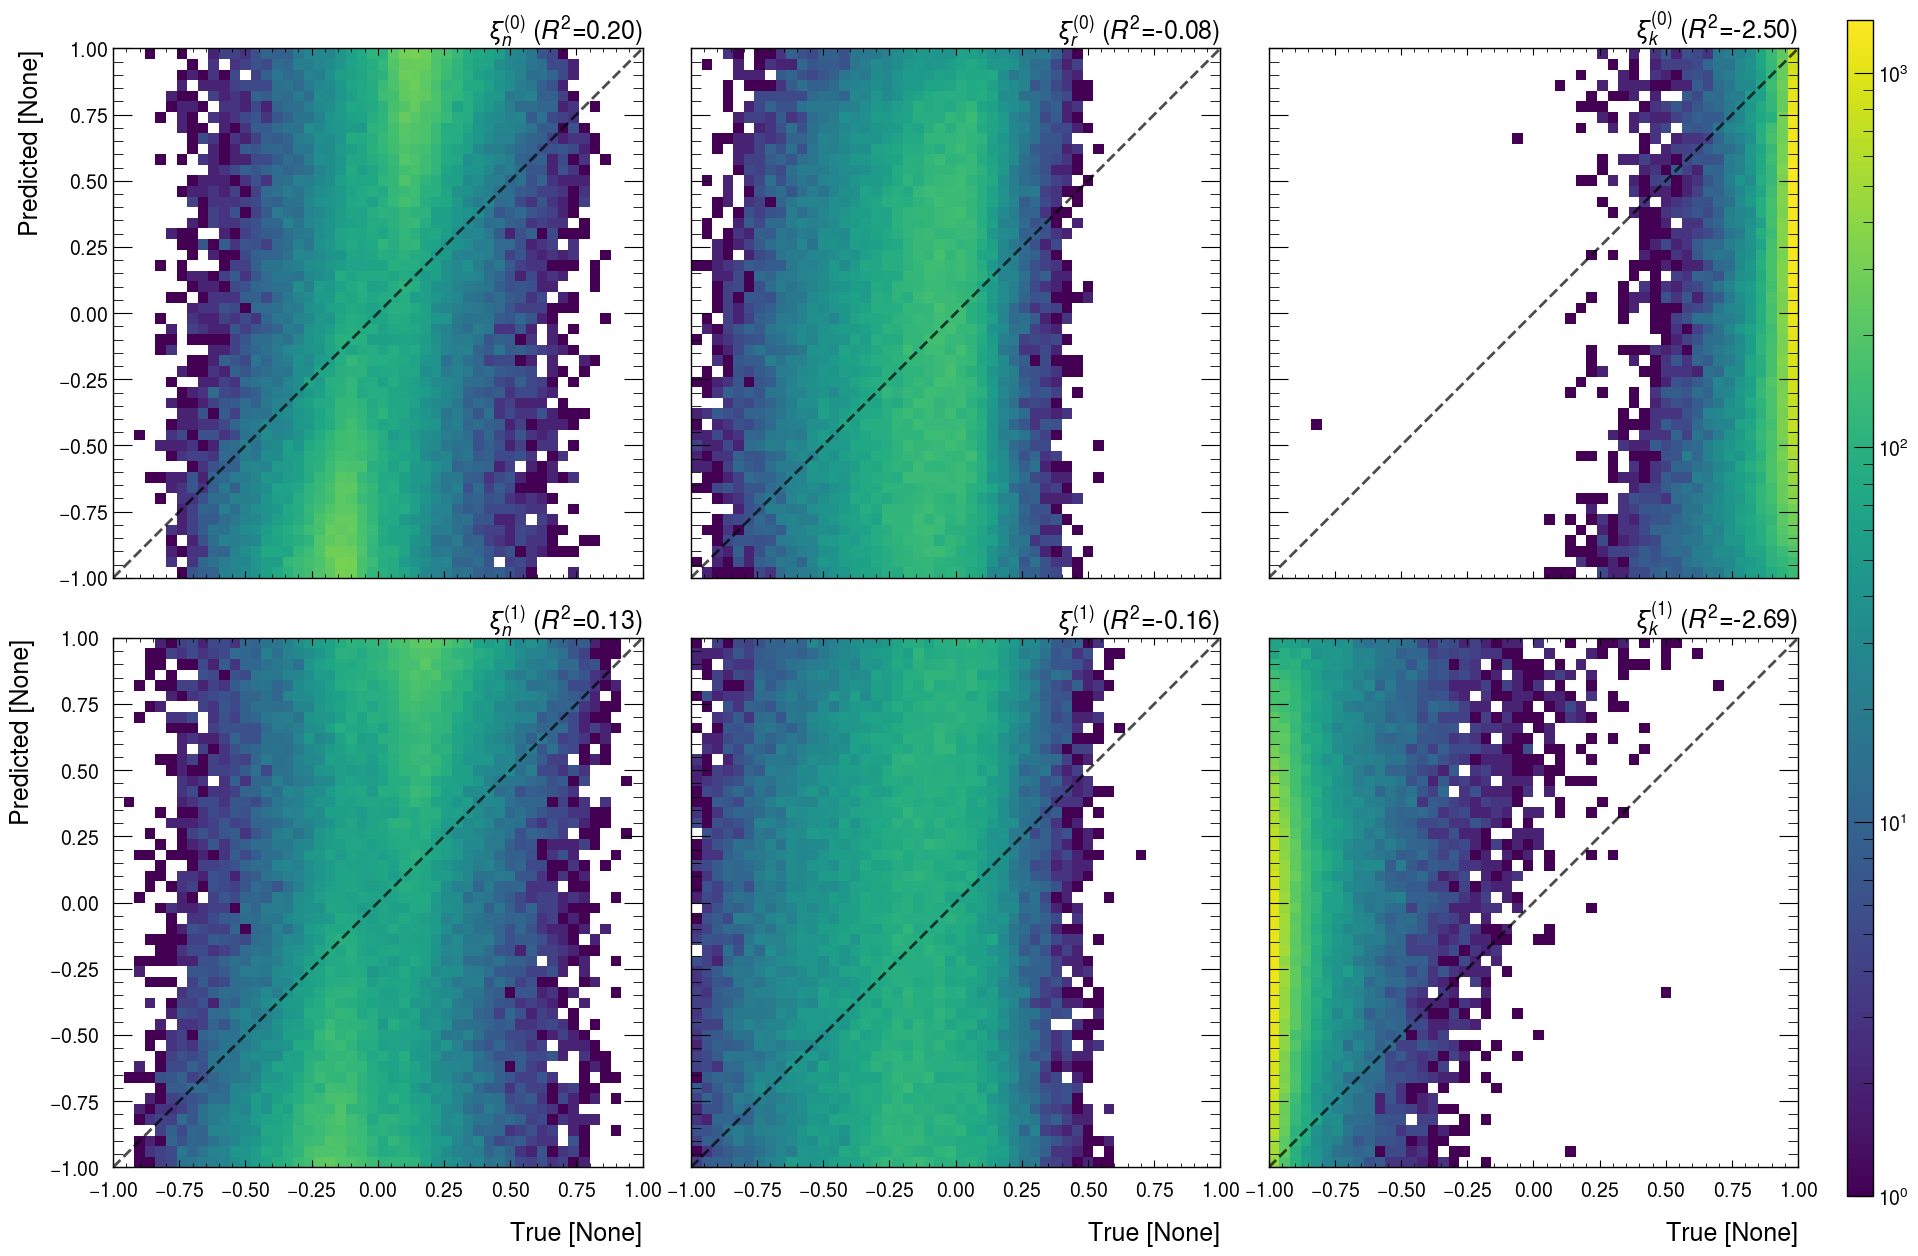

In [ ]:
xi_plot_true = [
    truth_xi_p[:, 0],
    truth_xi_p[:, 1],
    truth_xi_p[:, 2],
    truth_xi_n[:, 0],
    truth_xi_n[:, 1],
    truth_xi_n[:, 2],
]
xi_plot_pred = [
    xi_p[:, 0],
    xi_p[:, 1],
    xi_p[:, 2],
    xi_n[:, 0],
    xi_n[:, 1],
    xi_n[:, 2],
]
xi_plot_ranges = [[-1, 1]] * 6
xi_plot_labels = [
    r"$\xi^{(0)}_{n}$",
    r"$\xi^{(0)}_{r}$",
    r"$\xi^{(0)}_{k}$",
    r"$\xi^{(1)}_{n}$",
    r"$\xi^{(1)}_{r}$",
    r"$\xi^{(1)}_{k}$",
]
plot.hist_1d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    ranges=xi_plot_ranges,
    xlabel="[None]",
)
plot.hist_2d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    ranges=xi_plot_ranges,
    xlabel="True [None]",
    ylabel="Predicted [None]",
)
plt.close()

In [ ]:
t_end = time.time()
print(f"Time elapsed: {t_end - t_start:.2f} s")
print("Done!")

NameError: name 'time' is not defined